<a href="https://colab.research.google.com/github/phyop/220505_TensorFlow2/blob/main/220321_%E7%8C%AB%E7%8B%97%E8%AF%86%E5%88%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 猫狗识别

- 数据预处理：图像数据处理，准备训练和验证数据集
- 卷积网络模型：构建网络架构
- 过拟合问题：观察训练和验证效果，针对过拟合问题提出解决方法
- 数据增强：图像数据增强方法与效果
- 迁移学习：深度学习必备训练策略

![](https://drive.google.com/uc?export=view&id=1t9stFtY2XC78RV1uHnqg7fFNiTTq2rOa)

### 导入工具包

In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# https://docs.python.org/zh-tw/3/library/warnings.html

# warnings.filterwarnings(action, message='', category=Warning, module='', lineno=0, append=False)¶

# action 是以下字符串之一：
# "default" 为发出警告的每个位置（模块+行号）打印第一个匹配警告
# "error" 将匹配警告转换为异常 
# "ignore" 从不打印匹配的警告 
# "always" 总是打印匹配的警告
# "module" 为发出警告的每个模块打印第一次匹配警告（无论行号如何）
# "once" 无论位置如何，仅打印第一次出现的匹配警告

### 指定好数据路径（训练和验证）

In [ ]:
# base下建2個dir，分別是訓練與驗證，而各自下面又有圖像的n個分類
# 只要先給定base的絕對路徑，其他位置都用os.path.join來去做定位

# 数据所在文件夹
base_dir = '/content/drive/MyDrive/GoogleDrive_yaboaru/Colab Notebooks/220304_唐tensorflow2版本实战/第五章：猫狗识别实战/data/cats_and_dogs'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# 训练集
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# 验证集
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

### 构建卷积神经网络模型
- 几层都可以，大家可以随意玩
- 如果用CPU训练，可以把输入设置的更小一些，一般输入大小更主要的决定了训练速度

In [ ]:
# 因為conv的輸出會直接接激活，是一套的（目的是增加函數的非線性），所以激活會直接在conv的函數中當參數來做設置
# models.Sequential就是自己一層層的自定義設置下去，而不使用經典模型
# 一般MaxPooling都是各邊取1/2,所以(2, 2)幾乎是定版的了
# conv之後，一來，特征圖雖然越來越小，但張數就越來越多張
# 二來，大的特征圖，不代表越特征精細，裡面可能一堆空洞的低值，所以max pooling可以減少很多不必要的計算量。
model = tf.keras.models.Sequential([
    #如果训练慢，可以把数据设置的更小一些
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(2, 2), 

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    #为全连接层准备
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation='relu'),
    # 二分類的話，因為輸出一個值就夠了，大於0.5是狗，小於是貓。所以可以用0~1之間的sigmoid
    tf.keras.layers.Dense(1, activation='sigmoid') # 
])

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv3D

# Conv2D(參數)(前層輸出)，應該是TF的特殊語法
# 不輸入data_format，就會選擇default的channels_last
# 所以會自動把Input_shape對應到(batch_size, height, width, channels)

input_shape = (4, 28, 28, 3) # Batch = 4 的 28x28 RGB圖像
x = tf.random.normal(input_shape) # 等同np.random.normal(size=input_shape)
print(x.shape) # (4, 28, 28, 3)
y = tf.keras.layers.Conv2D(
2, 3, activation='relu', input_shape=input_shape)(x) # (...)中代表的是前層的輸出
print(y.shape) # (4, 26, 26, 2)

(4, 28, 28, 3)
(4, 26, 26, 2)


In [ ]:
model.summary()
# H2 = (H1-FH+2P)/S + 1 -> (64-3+0)/1 + 1 = 62 輸出shape
# 32個3通道的3*3卷積核 -> 32*3*（3*3） + 32個偏量b  = 896 個權重參數量

# 所謂權重參數，就是會根據每batch的訓練（正向傳遞算損失、反向微分算梯度）後，去調整改變的參數
# 正向傳播「像素是變數」，也就是不同像素乘上各自的權重做計算結果，看這個像素屬於哪個分類的幾率值
# 根據損失函數的數值，去判斷和正確分類的差值還有多少
# 反向傳播「權重是變數」(因爲輸入的像素不會改變)
# 為了讓損失函數趨向下，利用對變數做微分計算梯度，得到權重參數的調整值

# flatten後的shape是4608，接到512個神經元的全連接層 -> 4608*512 + 512個偏量b = 2359808 個權重參數
# 全連接對比前面conv的參數量，是7位數比5位數，所以傳統NN非常耗計算效能

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

配置训练器

In [ ]:
# model就是看得到的「實體網路結構」，比如位於哪一層、有幾個神經元、維度形狀長怎樣
# model.compile是「可選的數學算法」，比如loss常寫成複雜的數學公式，而優化器當然是演算法，評量方式也是一套數學算法
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-4),
              metrics=['acc'])

### 数据预处理

- 读进来的数据会被自动转换成tensor(float32)格式，分别准备训练和验证
- 图像数据归一化（0-1）区间

In [ ]:
# 图片生成器
# https://keras-cn.readthedocs.io/en/latest/preprocessing/image/

# ImageDataGenerator(可設參數多到爆炸)
# 用以生成一个batch的图像数据，训练时该函数会无限生成数据，
# 直到达到规定的epoch次数为止，支持实时数据提升。

# 主要是通過修改資料集中的圖片達成，使用平移、翻轉、亮度以及縮放的資料增強方法。
# 更多的訓練資料帶來的是更有效的深度學習模型，同時，資料增強技術會產生更多的圖片變體，
# 這些變體會提高模型對新圖片的泛化能力。

# 這邊把ImageDataGenerator，拿來做rescale歸一化成0~1間，殺雞用牛刀等級而已
train_datagen = ImageDataGenerator(rescale=1./255) 
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# tf.keras.preprocessing.image.ImageDataGenerator.flow_from_directory
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory
# 作用：獲取目錄的路徑並生成批量增強數據。
# return： 其中的DirectoryIterator產生元組是一個 numpy 數組，(x, y) -> (圖像，標籤)
# x是一批(batch_size, *target_size, channels)維度的圖像，y是對應標籤的 numpy 數組。

# tf.keras.preprocessing.image.DirectoryIterator是一個類，繼承自Iterator、Sequence
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/DirectoryIterator

train_generator = train_datagen.flow_from_directory(
        train_dir,  # 路徑下，不同圖像用不同資料夾裝，達成標籤的分類效果
        target_size=(64, 64),  # 因為訓練圖像有大有小，所以全部resize成一個大小
        batch_size=20, # 一次取一個batch的圖像讀到內存去做處理
        # 如果one-hot就是categorical，二分类用binary就可以
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(64, 64),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### 训练网络模型
- 直接fit也可以，但是通常咱们不能把所有数据全部放入内存，fit_generator相当于一个生成器，动态产生所需的batch数据
- steps_per_epoch相当给定一个停止条件，因为生成器会不断产生batch数据，说白了就是它不知道一个epoch里需要执行多少个step

In [ ]:
# 以前是model.fit，也就是一次從硬盤讀取所有資料到內存
# model.fit_generator是訓練的時候，要用誰就拿誰，動態的一次次去取batch到內存（記憶體）裡
history = model.fit_generator( 
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=20,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

# 跑完20個epoch之後的準確率，訓練集95%，驗證集76%，差了20%也太大了！所以明顯是過擬合
# Epoch 1/20
# 100/100 - 425s - loss: 0.6894 - acc: 0.5190 - val_loss: 0.6718 - val_acc: 0.5700 - 425s/epoch - 4s/step
# Epoch 20/20
# 100/100 - 16s - loss: 0.1721 - acc: 0.9465 - val_loss: 0.5797 - val_acc: 0.7630 - 16s/epoch - 160ms/step

Epoch 1/20
100/100 - 425s - loss: 0.6894 - acc: 0.5190 - val_loss: 0.6718 - val_acc: 0.5700 - 425s/epoch - 4s/step
Epoch 2/20
100/100 - 15s - loss: 0.6579 - acc: 0.6235 - val_loss: 0.6383 - val_acc: 0.6530 - 15s/epoch - 148ms/step
Epoch 3/20
100/100 - 15s - loss: 0.6071 - acc: 0.6730 - val_loss: 0.5977 - val_acc: 0.6850 - 15s/epoch - 148ms/step
Epoch 4/20
100/100 - 15s - loss: 0.5709 - acc: 0.7075 - val_loss: 0.5811 - val_acc: 0.7100 - 15s/epoch - 154ms/step
Epoch 5/20
100/100 - 15s - loss: 0.5393 - acc: 0.7340 - val_loss: 0.5696 - val_acc: 0.7120 - 15s/epoch - 152ms/step
Epoch 6/20
100/100 - 15s - loss: 0.5080 - acc: 0.7550 - val_loss: 0.6062 - val_acc: 0.6870 - 15s/epoch - 152ms/step
Epoch 7/20
100/100 - 15s - loss: 0.4731 - acc: 0.7880 - val_loss: 0.5774 - val_acc: 0.6990 - 15s/epoch - 151ms/step
Epoch 8/20
100/100 - 15s - loss: 0.4568 - acc: 0.7940 - val_loss: 0.5647 - val_acc: 0.7020 - 15s/epoch - 152ms/step
Epoch 9/20
100/100 - 15s - loss: 0.4279 - acc: 0.8135 - val_loss: 0.5494 

### 效果展示

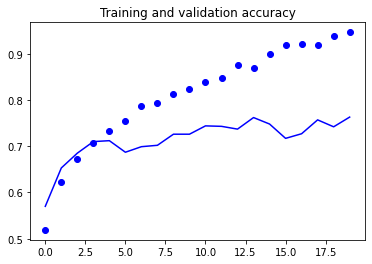

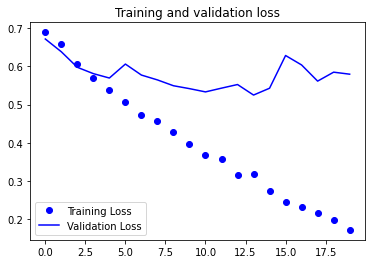

In [ ]:
import matplotlib.pyplot as plt

# 跑訓練時列印出的(train、validation)*(loss， accuracy)，其實就是model.fit的回傳
# 這些中間的歷史數據，可以用.history去取出，然後用pyplot做成視覺化輸出
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# 要做x軸，所以要知道有做幾次epoch。輸出一次，就代表一次epoch
# 所以4個輸出隨便抓一個，去算元素個數，就知道有幾個epoch，就可以做出x軸了
epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy') # plot就是開始畫線
plt.plot(epochs, val_acc, 'b', label='Validation accuracy') # 第二次用plot，就代表畫第2條線
plt.title('Training and validation accuracy')
plt.legend()

# 上面直接做plt.plot，但沒做plt.figure(xxx)，編譯器會自己幫忙補進去。
# 這邊的plt.figure() 沒給參數，所以意思就是，反正我就是要再創一張畫布，隨便你幫我default配置就好了
plt.figure() 

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

# 前面都完成後，要把圖表print出來
# print(xxx)是將文字做顯示，plt.show()是將圖表做顯示
plt.show() 

看起来完全过拟合了，如何解决呢？